# Import libraries

In [1]:
# Basic data manipulation libraries
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.tools.plotting import scatter_matrix

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Common model algorithms
from sklearn import linear_model, svm, tree, naive_bayes, ensemble
from xgboost import XGBRegressor

# Common model helpers
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

# Import Data

In [3]:
# my_data = pd.read_csv('data/train.csv')
my_data = pd.read_csv('data/test.csv')
my_data.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x90,x91,x92,x93,x94,x95,x96,x97,x98,x99
0,-0.000804,0.000970,-0.002136,-0.000659,-0.001872,0.002279,0.003041,-0.001780,0.001784,0.002268,...,-0.002738,T,0.001922,-0.000433,0.001075,-0.000262,-0.000204,-0.001700,-0.003856,0.002190
1,-0.002327,0.004325,0.000625,-0.004395,0.001026,0.001395,-0.004624,0.000635,-0.000145,0.001241,...,0.001692,H,0.004015,0.000405,0.000521,-0.001160,0.000273,0.003701,0.002455,-0.001783
2,0.000814,-0.003661,-0.000935,0.001207,-0.000047,0.001517,0.001798,-0.000567,0.002396,0.001114,...,-0.003197,W,-0.001202,-0.001986,0.001209,-0.000693,-0.000418,-0.002566,-0.002882,0.001013
3,-0.004367,0.006593,0.002954,-0.003492,-0.000912,-0.002938,-0.001492,-0.001161,0.001244,0.001165,...,0.003320,T,-0.002150,-0.002786,-0.000928,-0.000823,-0.002923,0.002205,-0.000257,-0.003741
4,0.000417,0.000569,0.002610,0.003285,-0.000181,-0.002413,-0.000885,0.000227,-0.000423,-0.001538,...,0.001545,W,-0.003160,0.000693,-0.001578,-0.000621,0.001237,0.001666,0.002137,-0.002681


In [4]:
print('Data dimension: {}'.format(my_data.shape))

Data dimension: (2000, 100)


# Data Cleaning

## Data Completeness

The goal of this step is to check if there are any missing values and to determine how to process missing values.

In [5]:
missing_rate = {}
for feature in my_data.columns:
    missing_rate[feature] = 100 * my_data[feature].isna().sum()/len(my_data[feature])
missing_rate_df = pd.DataFrame(list(missing_rate.values()), index=missing_rate.keys(), columns=['missing_rate'])
missing_rate_df['data_type'] = my_data.dtypes
missing_rate_df.head()

,missing_rate,data_type
x0,0.05,float64
x1,0.00,float64
x2,0.00,float64
x3,0.00,float64
x4,0.00,float64


In [6]:
print('The maximum missing rate is {}%'.format(np.max(missing_rate_df['missing_rate'])))

The maximum missing rate is 0.1%


The **train.csv** has very low missing value rate. The maximum missing rate is 0.05%.

In [7]:
categorical_variables = list(missing_rate_df.loc[missing_rate_df.data_type == 'object',].index)
categorical_variables

quantitative_variables = list(set(my_data.columns) - set(categorical_variables) - set('y'))
quantitative_variables

print('Number of categorical variables: {}'.format(len(categorical_variables)))
print('Number of quantitative variables: {}'.format(len(quantitative_variables)))

Number of categorical variables: 3
Number of quantitative variables: 97


### Impute missing values

* For categorical variables, we fill the missing values with mode.
* For quantitative variables, we visualize the distribution with boxplots and see if the variable has too many outliers. If yes, we fill missing values with **median**. Otherwise, we use the **mean**.

**Barplots on categorical variables**

In [8]:
df.sort_index()

NameError: name 'df' is not defined

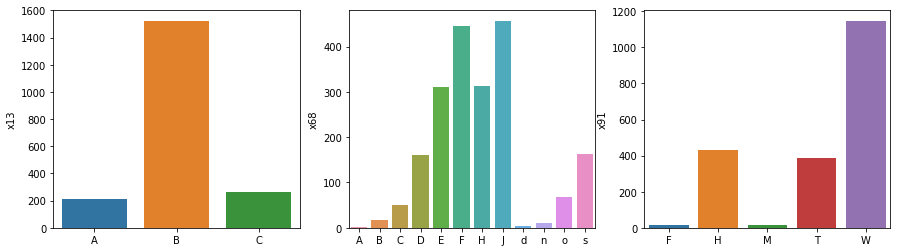

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
for i in range(len(categorical_variables)):
    f = categorical_variables[i]
    df = my_data[f].value_counts()
    df = df.sort_index()
    sns.barplot(df.index, df, ax=axs[i])

**Boxplots on quantitative variables**

In [ ]:
quantitative_variables = sorted(quantitative_variables)

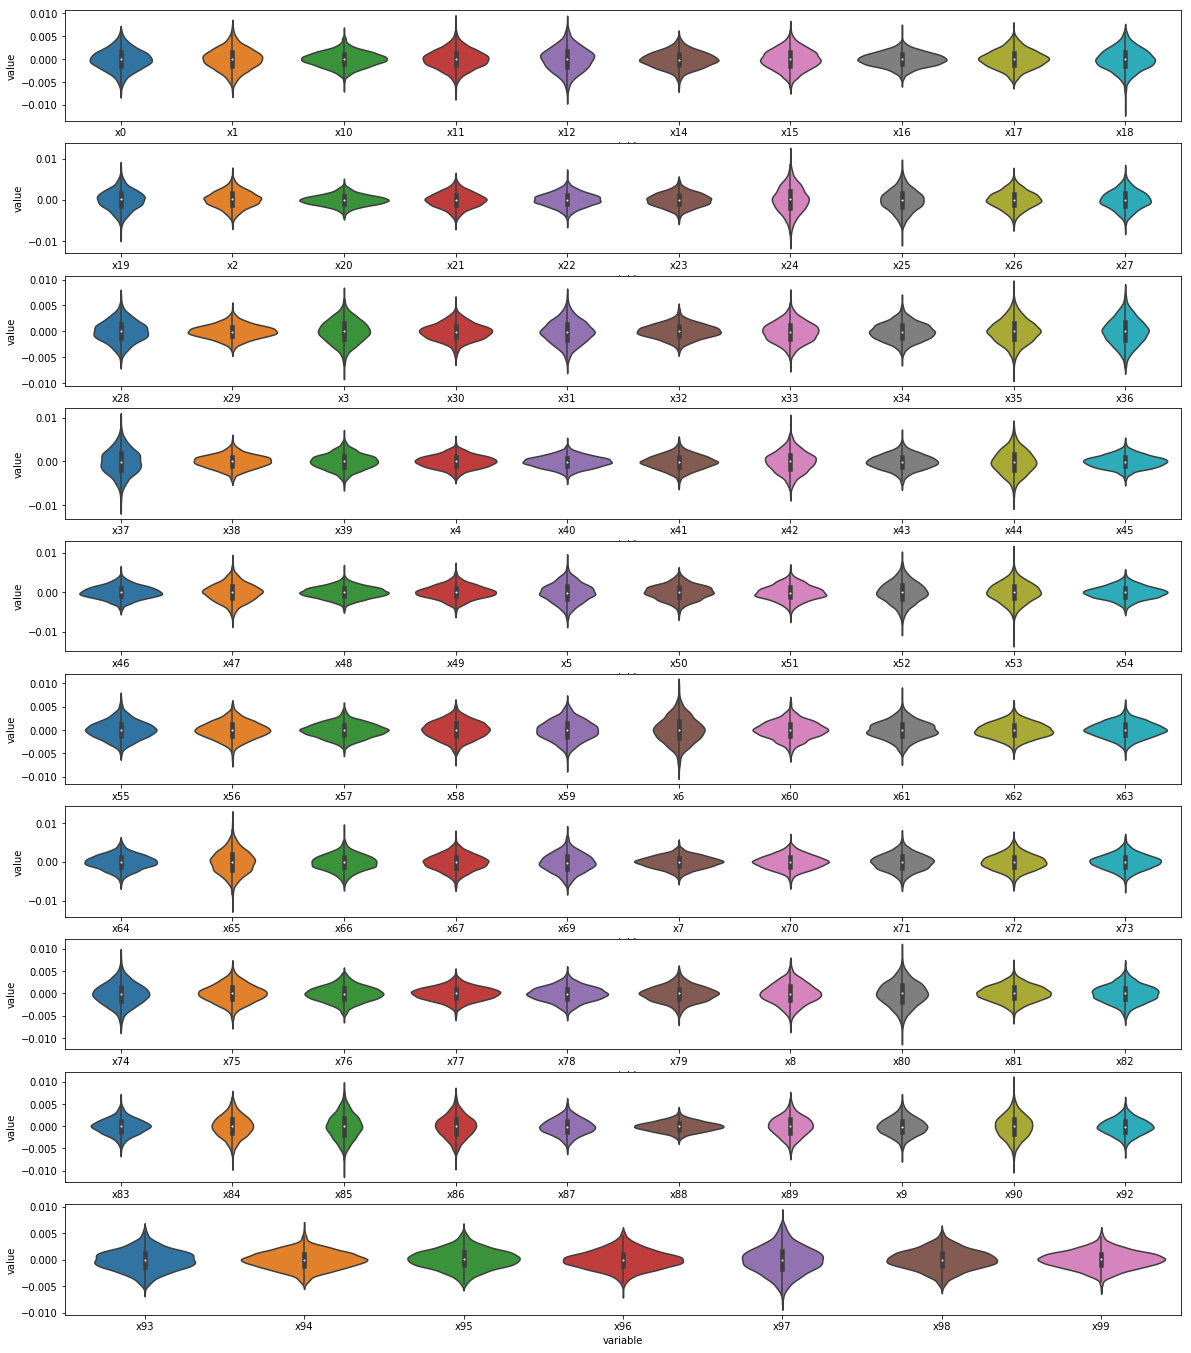

In [14]:
quantitative_variables = sorted(quantitative_variables)
fig, axs = plt.subplots(10, 1, figsize=(20,24))
for i in range(10):
    cols = quantitative_variables[i*10:(i+1)*10]
    if i == 9:
        cols = quantitative_variables[i*10:]
    df = my_data[cols]
    sns.violinplot(x="variable", y="value", data=df.melt(), ax=axs[i])

<span style="color:red">**Useful information from this step**</span>

+ The boxplots show that almost all quantitative variables have pretty much symmetric distribution with some extreme values. Both median and mean would be a good value for filling missing values.

In [206]:
# fill missing values in quantitative variables with median
for x in quantitative_variables:
    my_data[x].fillna(my_data[x].median(), inplace=True)
    
# fill missing values in categorical variables with mode
for x in categorical_variables:
    my_data[x].fillna(my_data[x].mode()[0], inplace=True)

Recheck the completeness of the data.

In [207]:
for x in my_data.columns:
    off = True
    missing_rate = my_data[x].isnull().sum()/my_data.shape[0]
    if  missing_rate != 0:
        print('{:<10} {}%'.format(x, missing_rate))
if off:
    print('No variable has missing value!')

No variable has missing value!


# Exploratory Data Analysis

Let's check the correlation among explanatory variables.

In [208]:
quant_corr_matrix = my_data[quantitative_variables].corr()

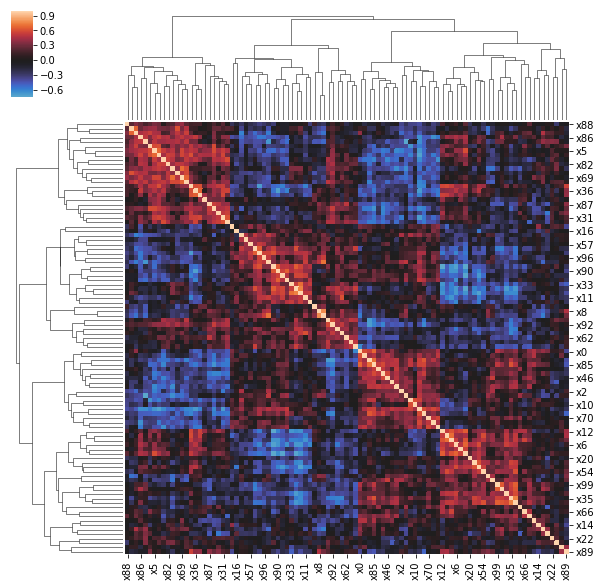

In [209]:
sns.clustermap(quant_corr_matrix, center=0)
plt.show()

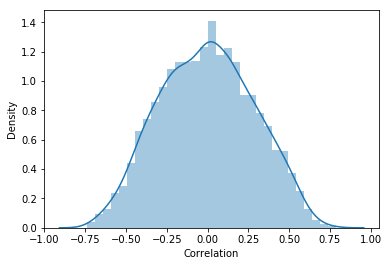

In [210]:
corrs = np.array(quant_corr_matrix)[np.triu_indices(97, 1)]
sns.distplot(corrs)
ax = plt.gca()
ax.set_xlabel('Correlation')
ax.set_ylabel('Density')
plt.show()

## Convert format

Dummy encode categorical data.

In [211]:
# one hot encode categorical variables
my_data_dummy_variables = pd.get_dummies(my_data[categorical_variables])

# drop original categorical variables and replace them with dummy encoded variables.
my_data.drop(categorical_variables, axis=1, inplace=True)
my_data = pd.concat([my_data_dummy_variables, my_data], axis=1)

(8000, 118)

# Model Data

## Split train and test data sets

In [215]:
Y = my_data.y
my_data.drop('y', axis=1, inplace=True)

In [216]:
train_X, test_X, train_Y, test_Y = model_selection.train_test_split(my_data, Y, test_size = 0.3, random_state=0)

# Machine Learning Algorithm

In [273]:
MLA = [
    # GLM
    linear_model.LinearRegression(),
    linear_model.Ridge(),
    linear_model.Lasso(),
    linear_model.ElasticNet(),
    
    # Trees
    tree.DecisionTreeRegressor(),
    tree.ExtraTreeRegressor(),
    
    # SVM 
    svm.LinearSVR(),
    svm.NuSVR(),
    svm.SVR(),
    
    # Ensemble Methods
    ensemble.AdaBoostRegressor(),
    ensemble.BaggingRegressor(),
    ensemble.ExtraTreesRegressor(),
    ensemble.GradientBoostingRegressor(),
    ensemble.RandomForestRegressor(),
    
    # xgboost
    XGBRegressor()
    
]

# run 10x cross validation
cv_split = model_selection.ShuffleSplit(n_splits=10, test_size=0.3, train_size=0.6, random_state=0)


# create table to store MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Score Mean', 
               'MLA Train Score Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns=MLA_columns)
MLA_predictions = pd.DataFrame({'Y': Y})

In [274]:
X = my_data
Y = np.array(Y)

In [275]:

row_index = 0
for alg in MLA:
    
    # set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    # train model
    cv_results = model_selection.cross_validate(alg, X, Y, cv=cv_split)
    
    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Score Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Score Mean'] = cv_results['test_score'].mean()
    
    MLA_compare.loc[row_index, 'MLA Test Score 3*STD'] = cv_results['test_score'].std()*3
    
    # save MLA predictions
    alg.fit(X, Y)
    MLA_predictions[MLA_name] = alg.predict(X)
    
    row_index+=1

In [276]:
MLA_compare.sort_values(by = ['MLA Test Score Mean'], ascending = False, inplace = True)
MLA_compare

,MLA Name,MLA Parameters,MLA Train Score Mean,MLA Train Score Mean,MLA Test Accuracy 3*STD,MLA Time,MLA Test Score Mean,MLA Test Score 3*STD
0,LinearRegression,"{'copy_X': True, 'fit_intercept': True, 'n_job...",0.999824,0.999824,NaN,0.0559756,0.999806,0.000113
12,GradientBoostingRegressor,"{'alpha': 0.9, 'criterion': 'friedman_mse', 'i...",0.940644,0.940644,NaN,4.08722,0.908007,0.007103
14,XGBRegressor,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.940446,0.940446,NaN,3.11345,0.907507,0.006927
11,ExtraTreesRegressor,"{'bootstrap': False, 'criterion': 'mse', 'max_...",1,1,NaN,0.9731,0.812147,0.018335
10,BaggingRegressor,"{'base_estimator': None, 'bootstrap': True, 'b...",0.964265,0.964265,NaN,2.64998,0.811587,0.012987
13,RandomForestRegressor,"{'bootstrap': True, 'criterion': 'mse', 'max_d...",0.963868,0.963868,NaN,2.62834,0.810129,0.014490
9,AdaBoostRegressor,"{'base_estimator': None, 'learning_rate': 1.0,...",0.824028,0.824028,NaN,4.02662,0.803509,0.017827
4,DecisionTreeRegressor,"{'criterion': 'mse', 'max_depth': None, 'max_f...",1,1,NaN,0.465218,0.590622,0.033273
5,ExtraTreeRegressor,"{'criterion': 'mse', 'max_depth': None, 'max_f...",1,1,NaN,0.101345,0.532007,0.089915
6,LinearSVR,"{'C': 1.0, 'dual': True, 'epsilon': 0.0, 'fit_...",0.529978,0.529978,NaN,0.104888,0.521592,0.019951


In [277]:
MLA_predictions

,Y,LinearRegression,Ridge,Lasso,ElasticNet,DecisionTreeRegressor,ExtraTreeRegressor,LinearSVR,NuSVR,SVR,AdaBoostRegressor,BaggingRegressor,ExtraTreesRegressor,GradientBoostingRegressor,RandomForestRegressor,XGBRegressor
0,0.309301,0.309532,0.270914,-0.015739,-0.015739,0.309301,0.309301,0.288150,0.265682,0.271405,0.633798,0.506034,0.309301,0.522259,0.359412,0.536463
1,0.423396,0.435753,-0.071979,-0.015739,-0.015739,0.423396,0.423396,-0.033272,-0.132649,-0.116786,0.218105,0.243558,0.423396,0.382530,0.529541,0.391888
2,0.132837,0.135635,-0.197637,-0.015739,-0.015739,0.132837,0.132837,-0.100285,-0.305042,-0.307351,0.343338,0.275176,0.132837,0.368515,0.274207,0.367025
3,0.340411,0.344864,0.030138,-0.015739,-0.015739,0.340411,0.340411,0.022476,0.041196,0.053437,0.095698,0.334256,0.340411,0.112621,0.085960,0.117353
4,0.719293,0.734451,0.033534,-0.015739,-0.015739,0.719293,0.719293,0.119578,-0.129735,-0.113197,0.420861,0.715421,0.719293,0.581414,0.665412,0.541740
5,-1.136778,-1.137299,-0.236284,-0.015739,-0.015739,-1.136778,-1.136778,-0.337980,-0.098466,-0.090657,-0.964045,-1.210436,-1.136778,-0.996711,-1.176180,-1.038942
6,0.233669,0.224960,0.191608,-0.015739,-0.015739,0.233669,0.233669,0.178141,0.269357,0.223160,0.569237,0.338228,0.233669,0.376657,0.326997,0.343415
7,-0.008195,-0.009712,0.068000,-0.015739,-0.015739,-0.008195,-0.008195,0.036631,0.079594,0.084316,-0.190956,-0.142365,-0.008195,-0.136144,-0.039782,-0.144147
8,-0.600602,-0.602646,-0.405366,-0.015739,-0.015739,-0.600602,-0.600602,-0.411171,-0.310465,-0.313959,-0.648578,-0.503038,-0.600602,-0.452636,-0.514791,-0.550865
9,-1.822254,-1.820396,-1.177396,-0.015739,-0.015739,-1.822069,-1.822254,-1.294177,-0.836189,-0.920652,-1.375647,-1.482641,-1.822254,-1.707978,-1.668738,-1.729266
